The dataset was used in the 1983 American Statistical Association Exposition. The data concerns city-cycle fuel consumption in miles per gallon, to be predicted in terms of 2 multivalued discrete and 4 continuous variables. 

Dataset: cars-dataset.csvView in a new window

Attribute Information:

Car Name – Name of the car

Cyl – No of cylinders in the car – Multivalued discrete

Disp – Displacement – continuous

Hp – Horsepower – continuous

Wt – Weight – continuous

Acc – Accleration – continuous

Yr – Model of the car – Multivalued discrete

Steps to follow:

1) EDA & Pre-processing (Make sure to remove all non-numeric entries from numeric columns)

2) Use pair plot or scatter matrix to visualize how the different variables are related (Hint: The amount of Gaussian curves in the plot should give a visual identification of different clusters existing in the dataset)

3) Use K Means or Hierarchical clustering to find out the optimal no of clusters in the data. Identify and separate the clusters

4) Use linear regression model on different clusters separately and print the coefficients of the models individually

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import scipy.stats as st

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage

from sklearn.metrics import silhouette_samples, silhouette_score

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_validate

In [2]:
df = pd.read_csv("cars-dataset.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
car name    398 non-null object
cyl         398 non-null int64
disp        398 non-null float64
hp          398 non-null object
wt          398 non-null int64
acc         398 non-null float64
yr          398 non-null int64
mpg         398 non-null float64
dtypes: float64(3), int64(3), object(2)
memory usage: 25.0+ KB


In [4]:
df.head()

,car name,cyl,disp,hp,wt,acc,yr,mpg
0,chevrolet chevelle malibu,8,307.0,130,3504,12.0,70,18.0
1,buick skylark 320,8,350.0,165,3693,11.5,70,15.0
2,plymouth satellite,8,318.0,150,3436,11.0,70,18.0
3,amc rebel sst,8,304.0,150,3433,12.0,70,16.0
4,ford torino,8,302.0,140,3449,10.5,70,17.0


In [5]:
# 'hp' seem to have some invalid values. Its column-type is object, though it contains numeric values.

In [6]:
df[df.hp.apply(lambda x: x.isnumeric() == False)]

,car name,cyl,disp,hp,wt,acc,yr,mpg
32,ford pinto,4,98.0,?,2046,19.0,71,25.0
126,ford maverick,6,200.0,?,2875,17.0,74,21.0
330,renault lecar deluxe,4,85.0,?,1835,17.3,80,40.9
336,ford mustang cobra,4,140.0,?,2905,14.3,80,23.6
354,renault 18i,4,100.0,?,2320,15.8,81,34.5
374,amc concord dl,4,151.0,?,3035,20.5,82,23.0


In [7]:
# ford pinto (year 1971) -> hp = 75  (Ref: https://www.automobile-catalog.com/make/ford_usa/pinto/pinto_runabout/1971.html)
# ford maverick (year 1974) -> hp = 84 (Ref: https://www.automobile-catalog.com/make/ford_usa/maverick_usa/maverick_usa_grabber/1974.html)
# renault lecar deluxe (year 1980) -> hp = 51 (Ref: https://www.ultimatespecs.com/car-specs/Renault/23003/Renault-Le-Car-De-Luxe.html)
# ford mustang cobra (year 1980) -> hp = 132 (Ref: https://www.caranddriver.com/reviews/a15142429/1980-ford-mustang-cobra-review/)
# renault 18i (year 1981) -> hp = 73 (Ref: https://www.ultimatespecs.com/car-specs/Renault/M39/18)
# amc concord dl (year 1982) -> hp = 82 (Ref: https://www.automobile-catalog.com/make/amc/concord/concord_2-door_dl/1982.html)

In [8]:
df[df['car name'] == 'ford pinto']

,car name,cyl,disp,hp,wt,acc,yr,mpg
32,ford pinto,4,98.0,?,2046,19.0,71,25.0
112,ford pinto,4,122.0,85,2310,18.5,73,19.0
130,ford pinto,4,122.0,80,2451,16.5,74,26.0
168,ford pinto,4,140.0,83,2639,17.0,75,23.0
174,ford pinto,6,171.0,97,2984,14.5,75,18.0
206,ford pinto,4,140.0,72,2565,13.6,76,26.5


In [9]:
df[df['car name'] == 'ford maverick']

,car name,cyl,disp,hp,wt,acc,yr,mpg
17,ford maverick,6,200.0,85,2587,16.0,70,21.0
100,ford maverick,6,250.0,88,3021,16.5,73,18.0
126,ford maverick,6,200.0,?,2875,17.0,74,21.0
155,ford maverick,6,250.0,72,3158,19.5,75,15.0
193,ford maverick,6,200.0,81,3012,17.6,76,24.0


In [10]:
df.loc[32, 'hp'] = '75'
df.loc[126, 'hp'] = '84'
df.loc[330, 'hp'] = '51'
df.loc[336, 'hp'] = '132'
df.loc[354, 'hp'] = '73'
df.loc[374, 'hp'] = '82'

In [11]:
df[df.hp.apply(lambda x: x.isnumeric() == False)]

,car name,cyl,disp,hp,wt,acc,yr,mpg


In [12]:
df.hp = df.hp.astype(int)
# Since, all missing values are imputed, converted the column type to int

In [13]:
df.isnull().sum()

car name    0
cyl         0
disp        0
hp          0
wt          0
acc         0
yr          0
mpg         0
dtype: int64

In [14]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
car name,398,305,ford pinto,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cyl,398,NaN,NaN,NaN,5.45477,1.701,3,4,4,8,8
disp,398,NaN,NaN,NaN,193.426,104.27,68,104.25,148.5,262,455
hp,398,NaN,NaN,NaN,104.143,38.4082,46,75,92,125,230
wt,398,NaN,NaN,NaN,2970.42,846.842,1613,2223.75,2803.5,3608,5140
acc,398,NaN,NaN,NaN,15.5681,2.75769,8,13.825,15.5,17.175,24.8
yr,398,NaN,NaN,NaN,76.0101,3.69763,70,73,76,79,82
mpg,398,NaN,NaN,NaN,23.5146,7.81598,9,17.5,23,29,46.6


In [15]:
df['car_brand'] = df['car name'].apply(lambda x : x.split()[0])

In [16]:
df.car_brand.sort_values().unique()

array(['amc', 'audi', 'bmw', 'buick', 'cadillac', 'capri', 'chevroelt',
       'chevrolet', 'chevy', 'chrysler', 'datsun', 'dodge', 'fiat',
       'ford', 'hi', 'honda', 'maxda', 'mazda', 'mercedes',
       'mercedes-benz', 'mercury', 'nissan', 'oldsmobile', 'opel',
       'peugeot', 'plymouth', 'pontiac', 'renault', 'saab', 'subaru',
       'toyota', 'toyouta', 'triumph', 'vokswagen', 'volkswagen', 'volvo',
       'vw'], dtype=object)

###### Observation: 
There seem to be some misspelt brand names like :
- 'vokswagen' instead of 'volkswagen', 
- 'toyouta' instead of 'toyota', 
- 'maxda' instead of ''mazda' and 
- 'chevroelt' instead of 'chevrolet'

Also,

- 'mercedes' and 'mercedes-benz' are same brands, so we can merge them into 'mercedes'

In [17]:
df.loc[df.car_brand== 'vokswagen','car_brand'] = 'volkswagen'
df.loc[df.car_brand== 'toyouta','car_brand'] = 'toyota'
df.loc[df.car_brand== 'maxda','car_brand'] = 'mazda'
df.loc[df.car_brand== 'chevroelt','car_brand'] = 'chevrolet'
df.loc[df.car_brand== 'mercedes-benz','car_brand'] = 'mercedes'

In [18]:
df.car_brand.sort_values().unique().tolist()

['amc',
 'audi',
 'bmw',
 'buick',
 'cadillac',
 'capri',
 'chevrolet',
 'chevy',
 'chrysler',
 'datsun',
 'dodge',
 'fiat',
 'ford',
 'hi',
 'honda',
 'mazda',
 'mercedes',
 'mercury',
 'nissan',
 'oldsmobile',
 'opel',
 'peugeot',
 'plymouth',
 'pontiac',
 'renault',
 'saab',
 'subaru',
 'toyota',
 'triumph',
 'volkswagen',
 'volvo',
 'vw']

# Common Functions:

In [19]:
# This function will generate single distplot for all given datasets, with mean and median lines.

def drawAllDistplots(dfList, nameList, colorList,  fig_size=(10,8), legend_loc='upper right', background_style='darkgrid'):
 
    if len(dfList) != len(nameList):
        print('Please provide names for all dataframes')
        return None
    
    if len(dfList) > len(colorList):
        print('Please provide color codes for all dataframes')
        return None

    skewness_kurtosis = ''
    
    sns.set(style=background_style)
    plt.figure(figsize=(15,8))
    
    for i in  range(0,len(dfList)):
        df = dfList[i]
        clr = colorList[i]
        name = nameList[i]
        s_k = name + ' --> skewness = ' + str(df.skew()) + ', kurtosis = ' + str(df.kurtosis()) + '\n'
        skewness_kurtosis = skewness_kurtosis + s_k
        ax=sns.distplot(df, hist=False, kde=True, label=name , color=clr, bins=10)
        ax.axvline(df.mean(),   color=clr, linestyle='--', label='%s, Mean = %0.2f' %(name, df.mean()))
        ax.axvline(df.median(), color=clr, linestyle='-',  label='%s, Median = %0.2f' %(name, df.median()))

    plt.legend(loc="upper right")
    plt.show()
    plt.close()
    print(skewness_kurtosis)

In [20]:
def drawCountPlot(x_axis=None, y_axis=None, figsz = (15,8), rotate_ticks=0, background_style='darkgrid' ,orderby=None, x_label=None, y_label=None):

    sns.set(style=background_style)
    plt.figure(figsize=figsz)
    plt.xticks(rotation=rotate_ticks)
    ax = sns.countplot(x=x_axis, y= y_axis, order=orderby)
    ax.set(xlabel= x_label, ylabel=y_label)
    plt.show()
    plt.close()

# EDA

#### Univariate Analysis - Categorical Variables

#### Car name / Car brand

In [21]:
df.car_brand.value_counts(normalize=True)*100

ford          12.814070
chevrolet     11.055276
plymouth       7.788945
amc            7.035176
dodge          7.035176
toyota         6.532663
datsun         5.778894
buick          4.271357
volkswagen     4.020101
pontiac        4.020101
honda          3.266332
mazda          3.015075
mercury        2.763819
oldsmobile     2.512563
peugeot        2.010050
fiat           2.010050
audi           1.758794
vw             1.507538
chrysler       1.507538
volvo          1.507538
renault        1.256281
opel           1.005025
subaru         1.005025
saab           1.005025
mercedes       0.753769
chevy          0.753769
bmw            0.502513
cadillac       0.502513
hi             0.251256
nissan         0.251256
capri          0.251256
triumph        0.251256
Name: car_brand, dtype: float64

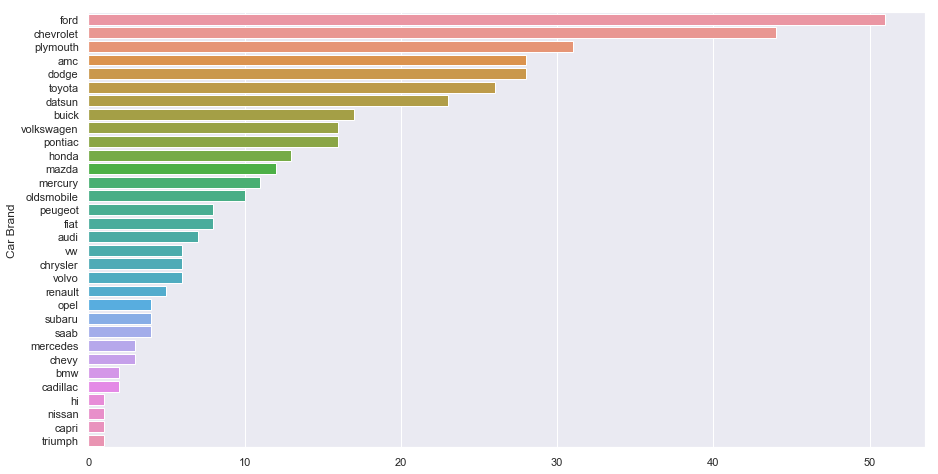

In [22]:
drawCountPlot(y_axis=df['car_brand'], y_label='Car Brand', background_style='darkgrid', orderby=df['car_brand'].value_counts().index)

Observation:
------------------

- Ford, followed by Chevrolet & Plymouth brands have highest representation in the dataset; in that order

### cyl

In [23]:
df.cyl.value_counts(normalize=True)*100

4    51.256281
8    25.879397
6    21.105528
3     1.005025
5     0.753769
Name: cyl, dtype: float64

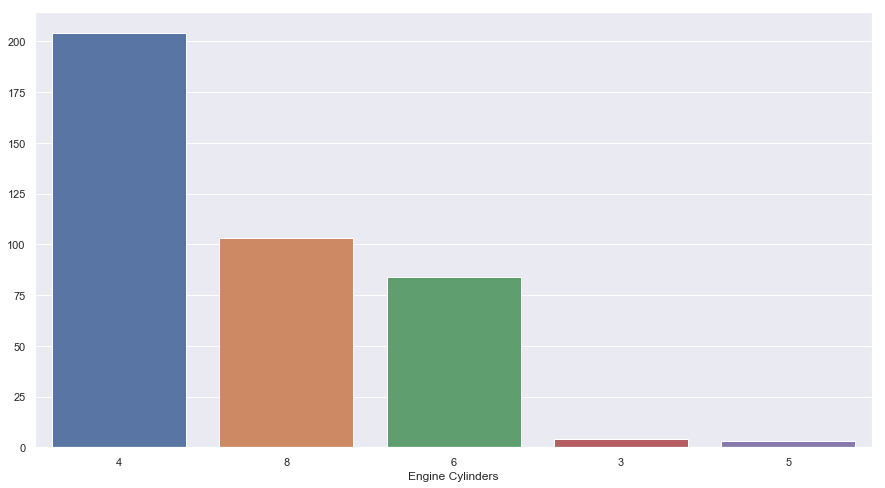

In [24]:
drawCountPlot(x_axis=df.cyl, x_label='Engine Cylinders' , orderby=df['cyl'].value_counts().index)

##### Observation:

- Most of the cars have 4-cylinder engines (almost 51%)
- 3 and 5 cylinder engines are very less compared to 4, 8 and 6 respectively.


#### yr

In [25]:
df.yr.value_counts(normalize=True)*100

73    10.050251
78     9.045226
76     8.542714
82     7.788945
75     7.537688
81     7.286432
80     7.286432
79     7.286432
70     7.286432
77     7.035176
72     7.035176
71     7.035176
74     6.783920
Name: yr, dtype: float64

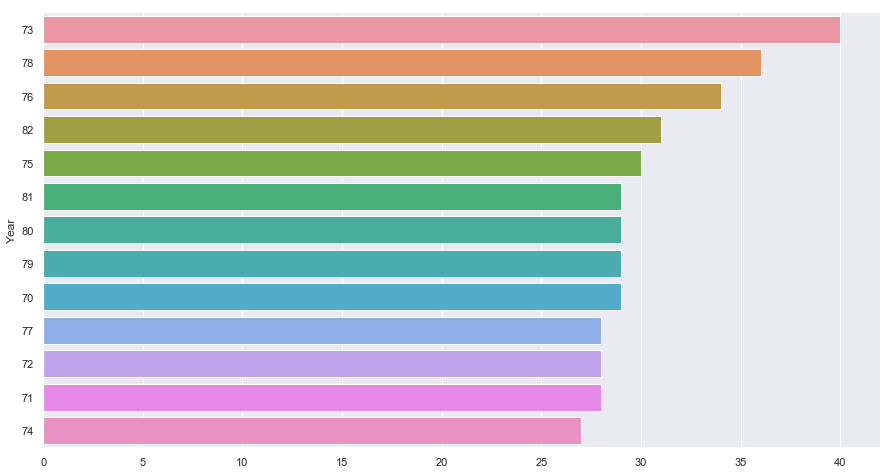

In [26]:
drawCountPlot(y_axis=df['yr'], y_label='Year', background_style='darkgrid', orderby=df['yr'].value_counts().index)

let's check displacement distributions for different major engine-types (4,6 and 8 cylinders). We will skip 3 and 5 cyl engines being minor classes in the dataset

In [27]:
df4 = df[df.cyl ==4]
df6 = df[df.cyl ==6]
df8 = df[df.cyl ==8]

In [28]:
corr = df.corr()

#### Univariate Analysis - Continuous Variables

### disp

###### Domain notes:

The most popular and widely used engine-type is the Internal Combustion (IC) engine. It is used in almost all cars and bikes. It is even used in industries to run large machines. An IC engine is also called a 'piston-engine', owing to the fact that it comprises a piston and cylinder arrangement, in which pressure generated by the burning of fuel is converted to proportional rotary motion of the engine.

Most IC engines these days come in multi-cylinder configurations. Modern car engines usually have 4, 6, 12, or even 16 cylinders powering their engines. Each of these cylinders holds a certain volume of 'fuel + air' mixture, which when ignited by their respective spark plugs, creates the pressure that pushes the piston down and sets the engine running.

The volume of this mixture that is swept or 'displaced' by the piston within a cylinder is that cylinder's displacement, and the combined displacement of all the cylinders inside a car's engine is called the engine's displacement. Its unit of measurement is 'cc', which stands for 'cubic centimeter', and 'lt', which is the abbreviation for 'liters'.

In [29]:
corr['disp'].sort_values(ascending=False)

disp    1.000000
cyl     0.950721
wt      0.932824
hp      0.895637
yr     -0.370164
acc    -0.543684
mpg    -0.804203
Name: disp, dtype: float64

Observation:

From domain notes, we understand that there's strong correlation between displacement and cylinder, which is also evident from above.

In [30]:
#sns.scatterplot(x='cyl', y='disp', data=df)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


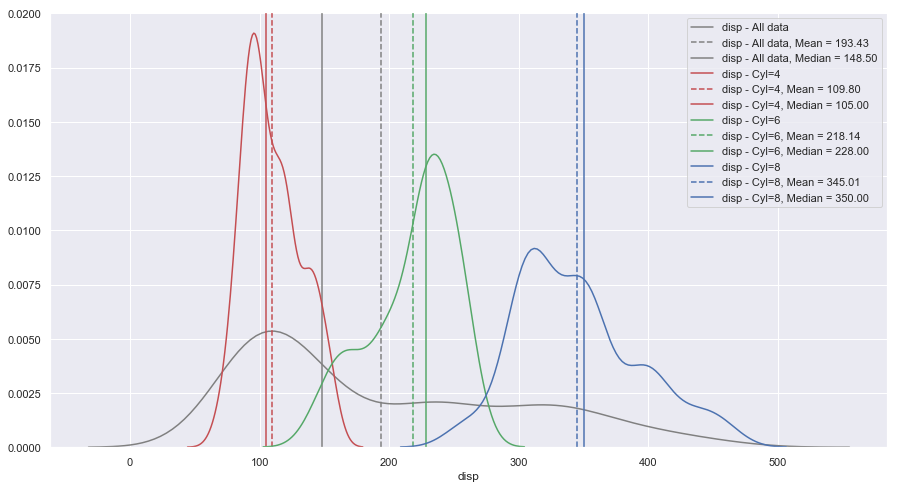

disp - All data --> skewness = 0.7196451643005952, kurtosis = -0.7465966295967594
disp - Cyl=4 --> skewness = 0.4416675615539831, kurtosis = -0.7442538678206461
disp - Cyl=6 --> skewness = -0.7713620299772358, kurtosis = -0.4751530954910619
disp - Cyl=8 --> skewness = 0.6012157481090544, kurtosis = -0.17155277620954967



In [31]:
dfList = [df['disp'], df4['disp'], df6['disp'], df8['disp']]
nameList = ['disp - All data', 'disp - Cyl=4', 'disp - Cyl=6', 'disp - Cyl=8']
colorList = ['grey', 'r', 'g', 'b']
drawAllDistplots(dfList, nameList, colorList, (10,8), 'upper right')

#### hp

##### Domain notes (HORSEPOWER AND TORQUE):

Horsepower and torque measure the amount of power an engine develops, with horsepower being the most commonly-used measurement.

- Torque, which is measured in pound-feet (lb-ft or ft-lbs), measures pulling power; when you step on the gas pedal and the seat pushes into your back, you are feeling torque. Trucks need lots of torque to get their heavy loads moving. 

- Horsepower is a function of torque and engine speed (RPM), and indicates how much sustained work the car can do. Racing cars need high horsepower to maintain high speeds. Generally, bigger-displacement engines develop more torque, but small engines can spin faster, which increases their horsepower output.

A car with high horsepower but low torque may feel sluggish from a stop, but will feel stronger as the engine spins faster and faster. A high-torque, low-hp engine will accelerate strongly from a stop, but will trail off as the engine speeds up (until the transmission shifts gears).

In [32]:
corr['hp'].sort_values(ascending=False)

hp      1.000000
disp    0.895637
wt      0.864187
cyl     0.840076
yr     -0.413070
acc    -0.689479
mpg    -0.777758
Name: hp, dtype: float64

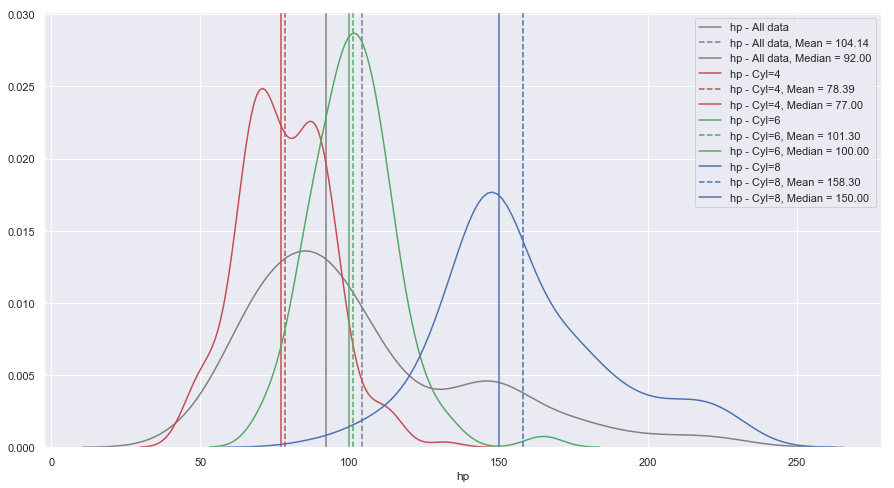

hp - All data --> skewness = 1.0940446924435192, kurtosis = 0.7218959667532436
hp - Cyl=4 --> skewness = 0.2794632248508319, kurtosis = 0.2907145542421845
hp - Cyl=6 --> skewness = 1.0160020831049306, kurtosis = 3.7778251834430403
hp - Cyl=8 --> skewness = 0.6487009847994352, kurtosis = 0.3397392357307809



In [33]:
dfList = [df['hp'], df4['hp'], df6['hp'], df8['hp']]
nameList = ['hp - All data', 'hp - Cyl=4', 'hp - Cyl=6', 'hp - Cyl=8']
colorList = ['grey', 'r', 'g', 'b']
drawAllDistplots(dfList, nameList, colorList, (10,8), 'upper right')

From domain notes, we can understand that horsepower (hp) is hightly correlated with displacement(disp). 
Correlation data above also indicate the same. As disp and cyl are highly correlated, hp has high correlation with cyl.

Data above indicate that horsepower has high positive correlation with weight, and negative correlation with acceleration and mgp as well.

##### wt

In [34]:
corr['wt'].sort_values(ascending=False)

wt      1.000000
disp    0.932824
cyl     0.896017
hp      0.864187
yr     -0.306564
acc    -0.417457
mpg    -0.831741
Name: wt, dtype: float64

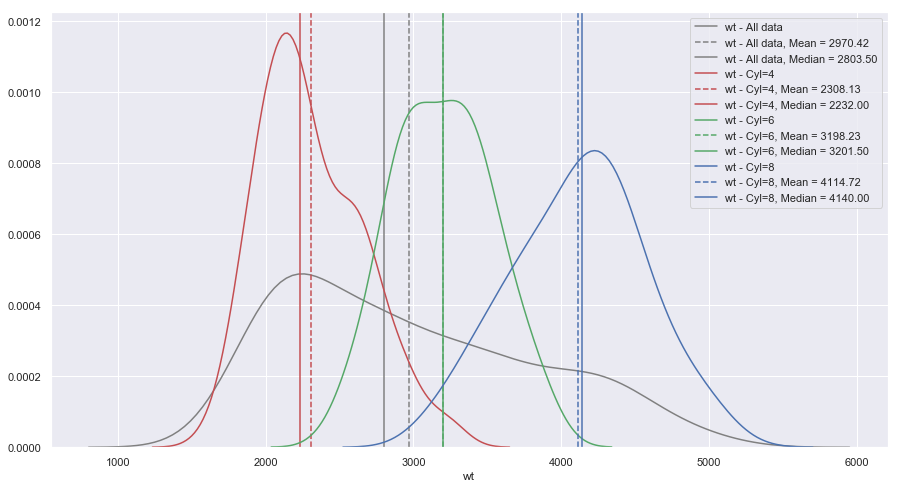

wt - All data --> skewness = 0.5310625125994629, kurtosis = -0.7855289051011454
wt - Cyl=4 --> skewness = 0.5606420406645036, kurtosis = -0.2197837844245507
wt - Cyl=6 --> skewness = 0.07695392204998872, kurtosis = -0.63140864543151
wt - Cyl=8 --> skewness = -0.10347838589487228, kurtosis = -0.40509562228711626



In [35]:
dfList = [df['wt'], df4['wt'], df6['wt'], df8['wt']]
nameList = ['wt - All data', 'wt - Cyl=4', 'wt - Cyl=6', 'wt - Cyl=8']
colorList = ['grey', 'r', 'g', 'b']
drawAllDistplots(dfList,nameList, colorList,(10,8), 'upper right')

#### acc

In [36]:
corr['acc'].sort_values(ascending=False)

acc     1.000000
mpg     0.420289
yr      0.288137
wt     -0.417457
cyl    -0.505419
disp   -0.543684
hp     -0.689479
Name: acc, dtype: float64

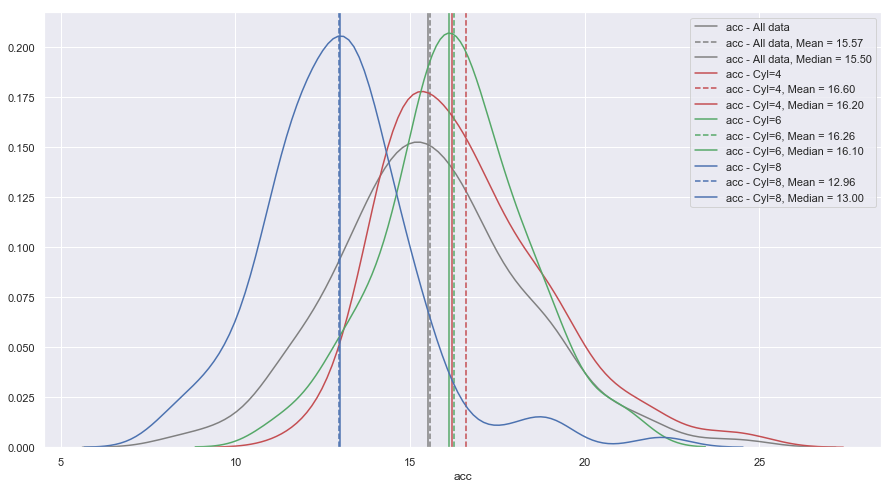

acc - All data --> skewness = 0.27877684462588986, kurtosis = 0.4194968829706842
acc - Cyl=4 --> skewness = 0.8933273428394898, kurtosis = 0.8833265130848096
acc - Cyl=6 --> skewness = 0.012843048365527585, kurtosis = 0.21966813452105471
acc - Cyl=8 --> skewness = 0.9232821841116764, kurtosis = 2.92925425855488



In [37]:
dfList = [df['acc'], df4['acc'], df6['acc'], df8['acc']]
nameList = ['acc - All data', 'acc - Cyl=4', 'acc - Cyl=6', 'acc - Cyl=8']
colorList = ['grey', 'r', 'g', 'b']
drawAllDistplots(dfList, nameList, colorList, (10,8), 'upper right')

##### mpg

In [38]:
corr['mpg'].sort_values(ascending=False)

mpg     1.000000
yr      0.579267
acc     0.420289
cyl    -0.775396
hp     -0.777758
disp   -0.804203
wt     -0.831741
Name: mpg, dtype: float64

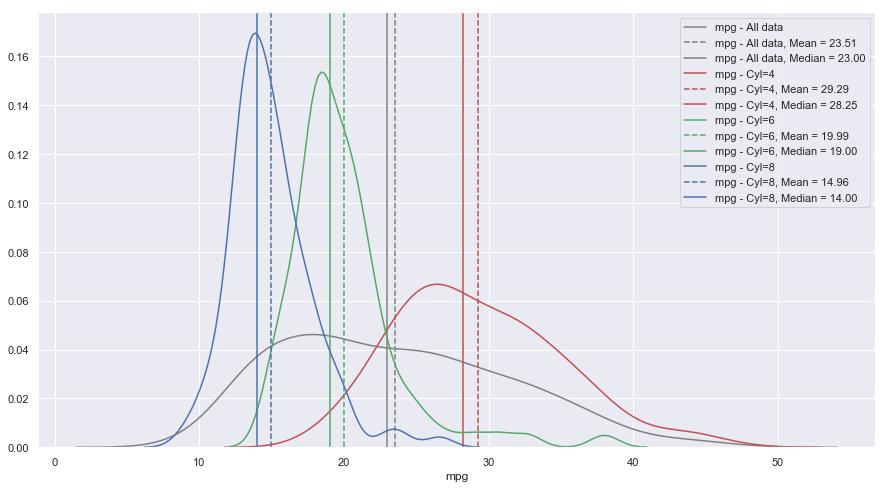

mpg - All data --> skewness = 0.45706634399491913, kurtosis = -0.5107812652123154
mpg - Cyl=4 --> skewness = 0.5387173602346621, kurtosis = 0.00011942328431180371
mpg - Cyl=6 --> skewness = 2.132681311660751, kurtosis = 6.74908285764371
mpg - Cyl=8 --> skewness = 1.1832545473579474, kurtosis = 2.8484173411939206



In [39]:
dfList = [df['mpg'], df4['mpg'], df6['mpg'], df8['mpg']]
nameList = ['mpg - All data', 'mpg - Cyl=4', 'mpg - Cyl=6', 'mpg - Cyl=8']
colorList = ['grey', 'r', 'g', 'b']
drawAllDistplots(dfList, nameList, colorList)

#### Bivariate & Multivariate Analysis

In [40]:
pd.crosstab(df.car_brand, df.cyl).style.background_gradient(cmap='Paired')

cyl,3,4,5,6,8
car_brand,,,,,
amc,0,3,0,17,8
audi,0,5,2,0,0
bmw,0,2,0,0,0
buick,0,3,0,7,7
cadillac,0,0,0,0,2
capri,0,1,0,0,0
chevrolet,0,15,0,11,18
chevy,0,1,0,0,2
chrysler,0,1,0,1,4


In [41]:
(pd.crosstab(df.cyl, df.car_brand, normalize='columns')*100).style.background_gradient(cmap='Paired')

car_brand,amc,audi,bmw,buick,cadillac,capri,chevrolet,chevy,chrysler,datsun,dodge,fiat,ford,hi,honda,mazda,mercedes,mercury,nissan,oldsmobile,opel,peugeot,plymouth,pontiac,renault,saab,subaru,toyota,triumph,volkswagen,volvo,vw
cyl,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33.3333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,10.7143,71.4286,100,17.6471,0,100,34.0909,33.3333,16.6667,86.9565,42.8571,100,35.2941,0,100,66.6667,33.3333,18.1818,100,10,100,87.5,32.2581,31.25,100,100,100,88.4615,100,100,66.6667,100
5,0,28.5714,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33.3333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,60.7143,0,0,41.1765,0,0,25,0,16.6667,13.0435,14.2857,0,25.4902,0,0,0,33.3333,36.3636,0,20,0,12.5,35.4839,25,0,0,0,11.5385,0,0,33.3333,0
8,28.5714,0,0,41.1765,100,0,40.9091,66.6667,66.6667,0,42.8571,0,39.2157,100,0,0,0,45.4545,0,70,0,0,32.2581,43.75,0,0,0,0,0,0,0,0


Observation:
------------------

- Cylinder = 3 ---> Only Mazda has 3 cylinder engine cars.
- Cylinder = 4 ---> 
    - Almost all the brands manufacture  4 cylinder engine cars, except calillac and hi.
    - Toyata followed by Datsun has the highest number of 4 cylinder engine cars.
    - Many of the brands manufacture only 4-cylinder cars. eg. bmw, honda, nissan, opel etc.
- Cylinder = 5 ---> Only Audi followed by Mercedes have 5 cylinder engine cars. 
- Cylinder = 6 ---> Amc followed by Plymouth has highest number of 6 cylinder engine cars.
- Cylinder = 8 ---> 
    - Ford followed by Chevrolet has highest number of 8 cylinder engine cars.
    - Interestingly, many companies who have almost equal % of 4, 6 and 8 cylinder engine cars. eg. ford, chevrolet.
    - Cadilac has only 8 cylinder engine cars.

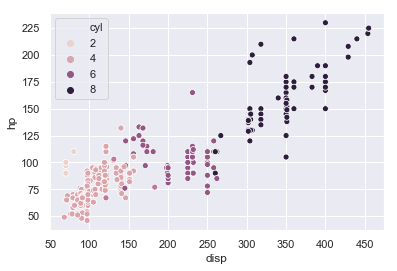

In [42]:
sns.scatterplot(x=df.disp, y=df.hp , hue=df.cyl)

Observation:
------------------

- Lower number of cylinder engine cars, have lower displacement and lower hp as well.
- We can see clear cylinder-wise clusters in the above plot

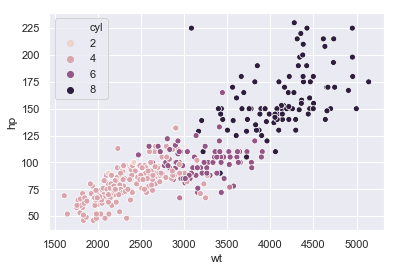

In [43]:
sns.scatterplot(x=df.wt, y=df.hp, hue=df.cyl)

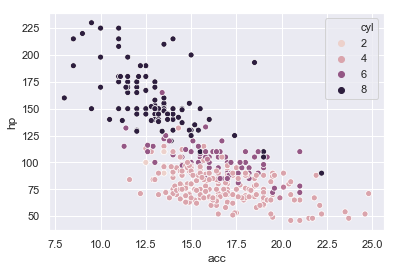

In [44]:
sns.scatterplot(x=df.acc, y=df.hp, hue=df.cyl)

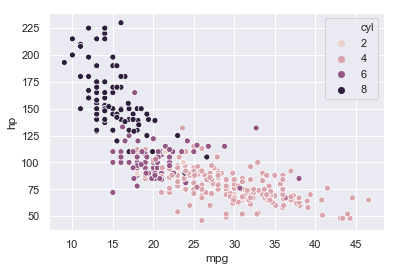

In [45]:
sns.scatterplot(x=df.mpg, y=df.hp, hue=df.cyl)

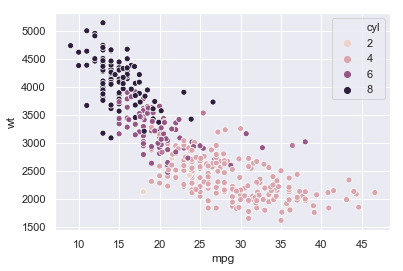

In [46]:
sns.scatterplot(x=df.mpg, y=df.wt, hue=df.cyl)

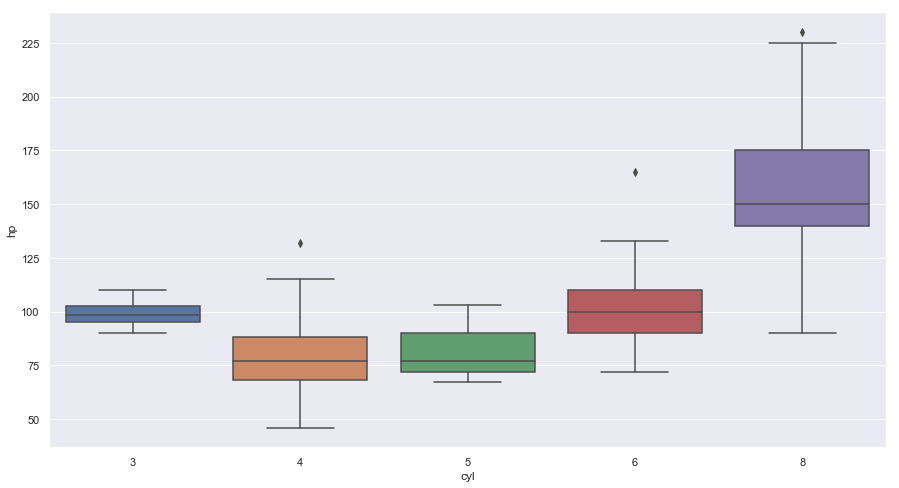

In [47]:
plt.figure(figsize=(15,8))
sns.boxplot('cyl', 'hp' , data=df, orient='v')
plt.show()
plt.close()

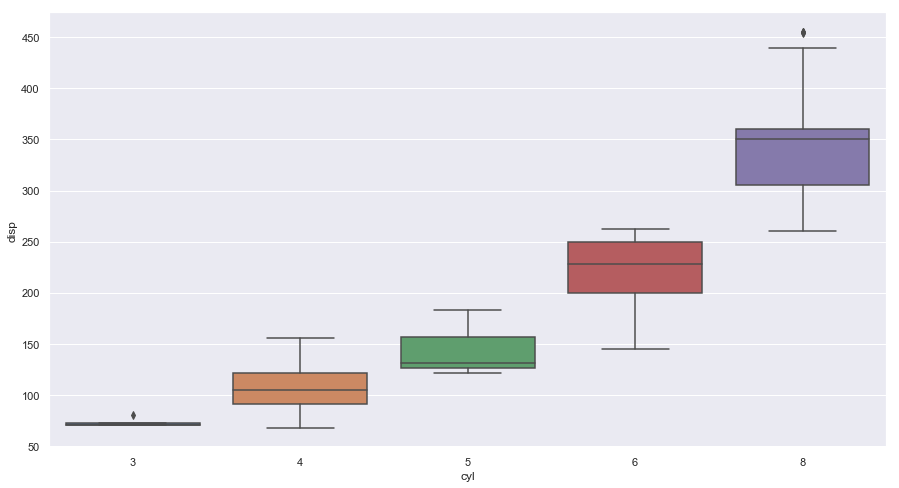

In [48]:
plt.figure(figsize=(15,8))
sns.boxplot('cyl', 'disp' , data=df)
plt.show()
plt.close()

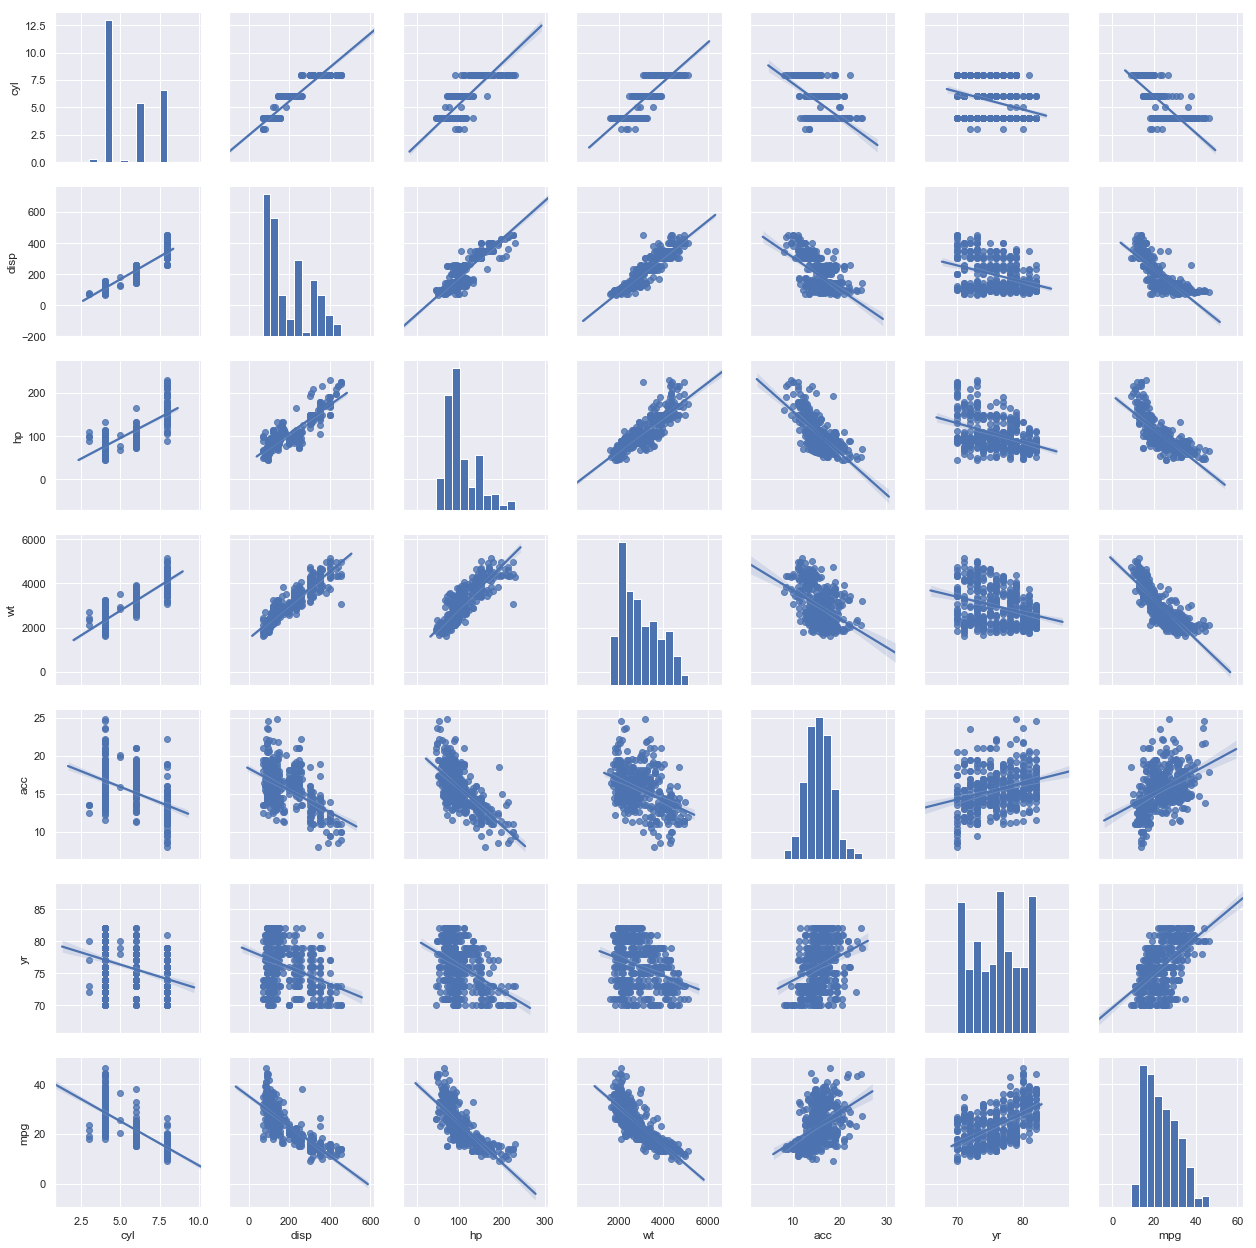

In [49]:
sns.pairplot(df, kind='reg')

### Global Variables

In [50]:
seed = 630871
initial_clusters = 4

### Use K Means or Hierarchical clustering to find out the optimal no of clusters in the data. Identify and separate the clusters


In [51]:
X1 = df.drop(['car name', 'yr', 'car_brand'], axis=1).apply(st.zscore)
X2 = pd.get_dummies(df[['yr', 'car_brand']], columns=['yr', 'car_brand'])
X = X1.join(X2)
X.head()

,cyl,disp,hp,wt,acc,mpg,yr_70,yr_71,yr_72,yr_73,...,car_brand_plymouth,car_brand_pontiac,car_brand_renault,car_brand_saab,car_brand_subaru,car_brand_toyota,car_brand_triumph,car_brand_volkswagen,car_brand_volvo,car_brand_vw
0,1.498191,1.090604,0.674057,0.630870,-1.295498,-0.706439,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.498191,1.503514,1.586467,0.854333,-1.477038,-1.090751,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.498191,1.196232,1.195434,0.550470,-1.658577,-0.706439,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,1.498191,1.061796,1.195434,0.546923,-1.295498,-0.962647,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.498191,1.042591,0.934746,0.565841,-1.840117,-0.834543,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
model_kmean = KMeans(n_clusters=initial_clusters, random_state=seed).fit(X)
sum(np.min(cdist(X, model_kmean.cluster_centers_, metric='euclidean'), axis=1)**2/X.shape[0])

3.0416656063287673

In [53]:
distortions = []
cl = range(1, 9)
for c in cl:
    model_kmean = KMeans(n_clusters=c, random_state=seed).fit(X)
    distortion_c = sum(np.min(cdist(X, model_kmean.cluster_centers_, metric='euclidean'), axis=1)**2/X.shape[0])
    distortions.append(distortion_c)

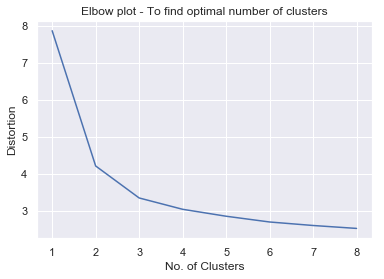

In [54]:
plt.title("Elbow plot - To find optimal number of clusters")
plt.xlabel("No. of Clusters")
plt.ylabel("Distortion")
plt.plot(cl, distortions)

In [55]:
optimal_clusters = 2

In [56]:
model_kmean = KMeans(n_clusters=optimal_clusters, random_state=seed).fit(X)

In [57]:
model_kmean.cluster_centers_

array([[-5.21963874e-01, -5.11115151e-01, -5.02677403e-01,
        -4.75860813e-01,  3.43790524e-01,  3.88850280e-01,
         3.74149660e-02,  7.14285714e-02,  5.10204082e-02,
         6.80272109e-02,  7.48299320e-02,  8.16326531e-02,
         8.50340136e-02,  6.80272109e-02,  9.52380952e-02,
         6.80272109e-02,  9.86394558e-02,  9.52380952e-02,
         1.05442177e-01,  6.46258503e-02,  2.38095238e-02,
         6.80272109e-03,  3.06122449e-02,  1.90819582e-17,
         3.40136054e-03,  8.84353741e-02,  3.40136054e-03,
         6.80272109e-03,  7.82312925e-02,  5.44217687e-02,
         2.72108844e-02,  1.05442177e-01,  9.54097912e-18,
         4.42176871e-02,  4.08163265e-02,  1.02040816e-02,
         2.04081633e-02,  3.40136054e-03,  1.36054422e-02,
         1.36054422e-02,  2.72108844e-02,  7.14285714e-02,
         3.06122449e-02,  1.70068027e-02,  1.36054422e-02,
         1.36054422e-02,  8.84353741e-02,  3.40136054e-03,
         5.44217687e-02,  2.04081633e-02,  2.04081633e-0

In [58]:
#Store centroids in a dataframe with column names from the original dataset given
pd.DataFrame(columns=X.columns, data=model_kmean.cluster_centers_)

,cyl,disp,hp,wt,acc,mpg,yr_70,yr_71,yr_72,yr_73,...,car_brand_plymouth,car_brand_pontiac,car_brand_renault,car_brand_saab,car_brand_subaru,car_brand_toyota,car_brand_triumph,car_brand_volkswagen,car_brand_volvo,car_brand_vw
0,-0.521964,-0.511115,-0.502677,-0.475861,0.343791,0.38885,0.037415,0.071429,0.05102,0.068027,...,0.071429,0.030612,0.017007,1.360544e-02,1.360544e-02,8.843537e-02,3.401361e-03,5.442177e-02,2.040816e-02,2.040816e-02
1,1.475552,1.444883,1.421030,1.345222,-0.971869,-1.09925,0.173077,0.067308,0.12500,0.192308,...,0.096154,0.067308,0.000000,-1.734723e-17,-1.734723e-17,6.938894e-17,-4.336809e-18,-6.938894e-17,2.775558e-17,2.775558e-17


In [59]:
labels = model_kmean.labels_
labels.shape

(398,)

In [60]:
len(labels[labels==0])

294

In [61]:
len(labels[labels==1])

104

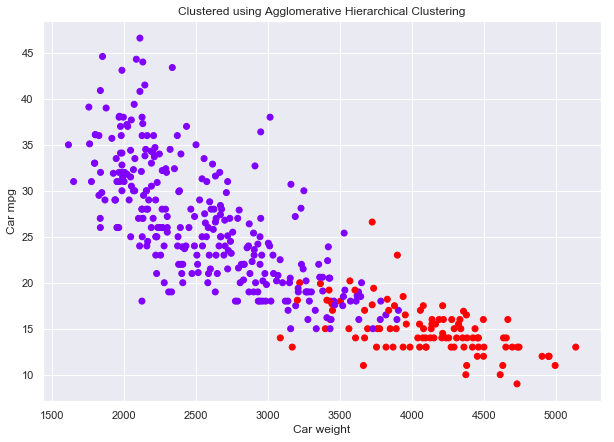

In [62]:
plt.figure(figsize=(10,7))
plt.title('Clustered using Agglomerative Hierarchical Clustering')
plt.xlabel("Car weight")
plt.ylabel("Car mpg")
plt.scatter(x = df.wt , y=df.mpg, c=labels, cmap='rainbow' )
plt.show()
plt.close()

In [63]:
# Perform Silhoutte Analysis to validate Clusters

sil_score = silhouette_score(X, model_kmean.labels_, random_state=seed)
sil_score

0.417414963240951

### Hierarchical Clustering

In [64]:
Z = linkage(X, 'ward', metric='euclidean')
Z.shape

(397, 4)

In [65]:
Z

array([[1.29000000e+02, 1.45000000e+02, 2.15122934e-01, 2.00000000e+00],
       [6.40000000e+01, 7.50000000e+01, 2.32529276e-01, 2.00000000e+00],
       [8.70000000e+01, 1.15000000e+02, 2.79275305e-01, 2.00000000e+00],
       ...,
       [7.89000000e+02, 7.91000000e+02, 1.41280659e+01, 2.20000000e+02],
       [7.87000000e+02, 7.92000000e+02, 2.60990857e+01, 2.99000000e+02],
       [7.90000000e+02, 7.93000000e+02, 5.36328746e+01, 3.98000000e+02]])

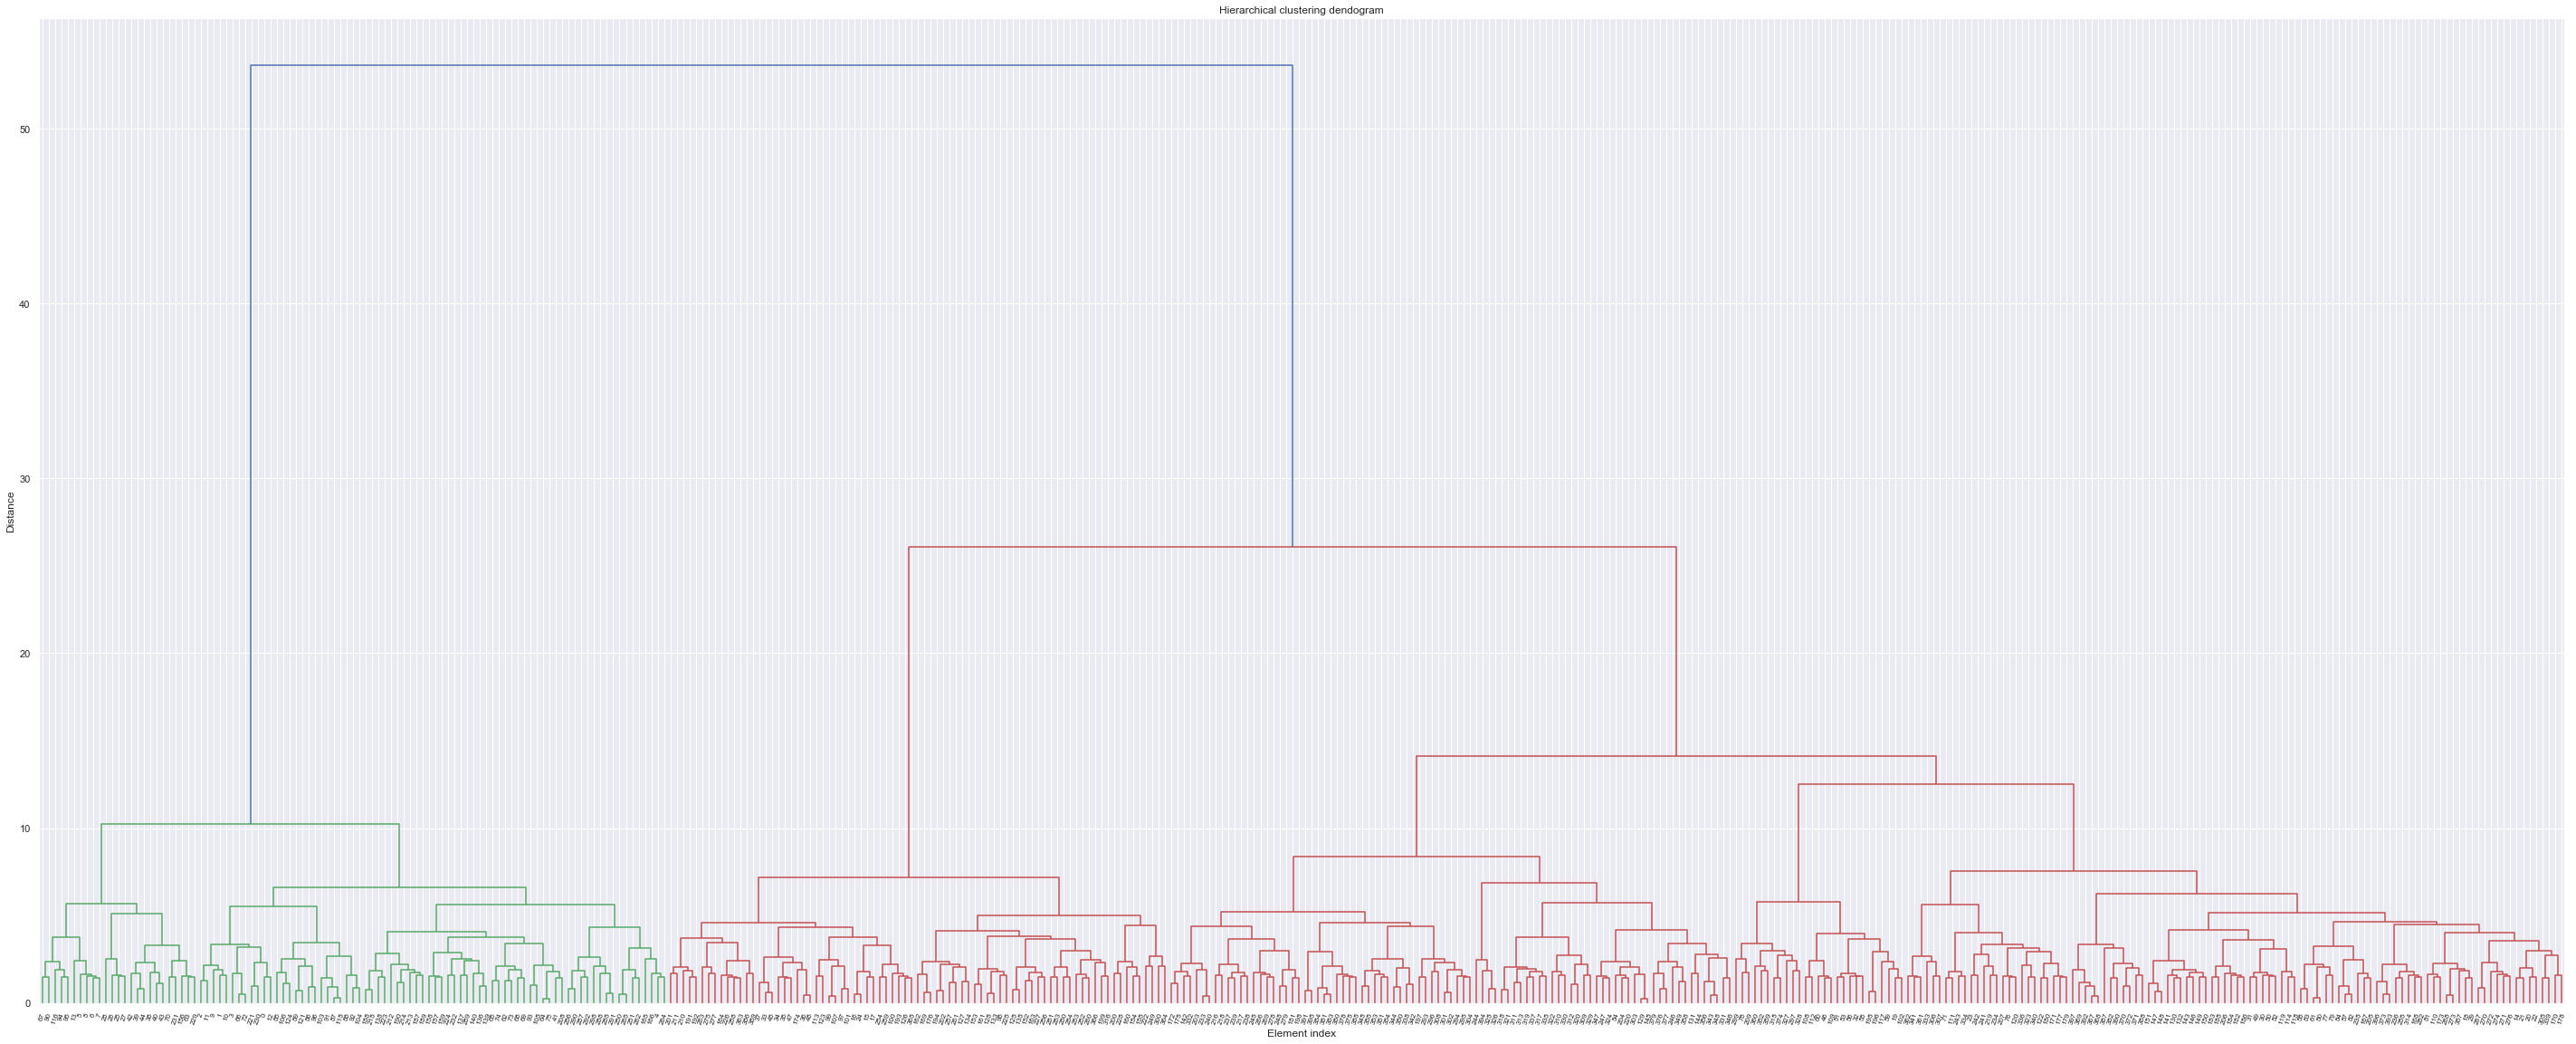

In [66]:
plt.figure(figsize=(50,20))
plt.title("Hierarchical clustering dendogram")
plt.xlabel("Element index")
plt.ylabel("Distance")

dendrogram(Z,
          distance_sort=False,
          leaf_rotation=70,
          leaf_font_size=8)

plt.show()
plt.close()

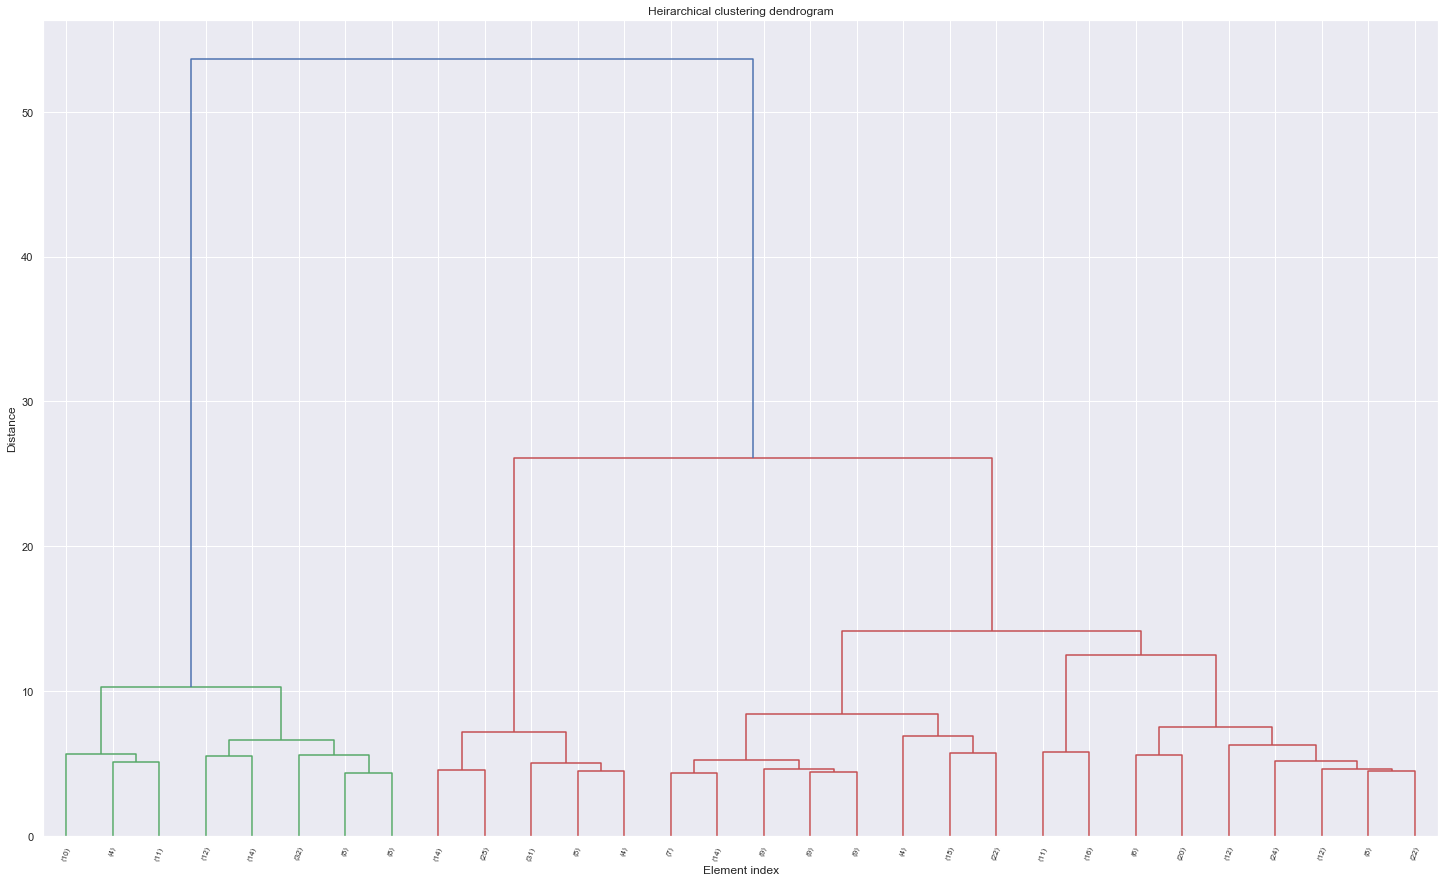

In [67]:
plt.figure(figsize=(25,15))
plt.title('Heirarchical clustering dendrogram')
plt.xlabel("Element index")
plt.ylabel("Distance")
dendrogram(Z, 
           distance_sort=False,    
           leaf_rotation=70,  # rotates the x axis labels
           leaf_font_size=8,  # font size for the x axis labels
           truncate_mode='lastp'
        )
plt.show()
plt.close()

In [68]:
optimal_distance = 30

In [69]:
clusters = fcluster(Z, optimal_distance, criterion='distance')
clusters

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2,

In [70]:
unique, counts = np.unique(clusters, return_counts=True)
dict(zip(unique, counts))

{1: 99, 2: 299}

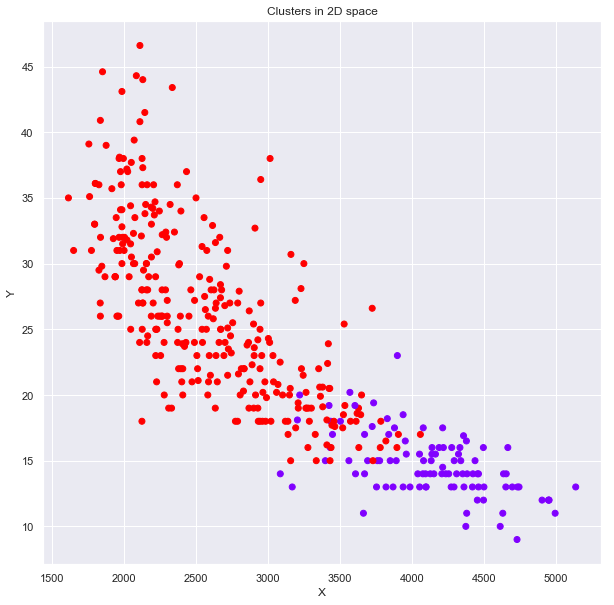

In [71]:
plt.figure(figsize=(10,10))
plt.title("Clusters in 2D space")
plt.xlabel("X")
plt.ylabel("Y")
plt.scatter(df.wt, df.mpg, c=clusters,  cmap='rainbow')

###  Use linear regression model on different clusters separately and print the coefficients of the models individually

In [72]:
df_lm = df.copy()
df_lm['Cluster'] = clusters
df_lm = pd.get_dummies(data=df_lm, columns=['yr', 'cyl'])
df_lm.drop(['car name', 'car_brand'], axis=1, inplace=True)

df_coef = pd.DataFrame(index=np.append('intercept', X.columns), columns=['Cluster1', 'Cluster2', 'All'])

cluster1 = df_lm[df_lm.Cluster==1]
cluster2 = df_lm[df_lm.Cluster==2]

df_coef.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52 entries, intercept to car_brand_vw
Data columns (total 3 columns):
Cluster1    0 non-null object
Cluster2    0 non-null object
All         0 non-null object
dtypes: object(3)
memory usage: 1.6+ KB


In [73]:
Y = cluster1['mpg']
X = cluster1.drop('mpg', axis=1)


X_train, Y_train, X_test, Y_test = train_test_split(X, Y, test_size=0.3, random_state=seed)
model_lm = LinearRegression().fit(X, Y)

df_coef['Cluster1'] = np.append(model_lm.intercept_, model_lm.coef_)
df_coef

ValueError: Length of values does not match length of index

In [ ]:
Y = cluster2['mpg']
X = cluster2.drop('mpg', axis=1)

X_train, Y_train, X_test, Y_test = train_test_split(X, Y, test_size=0.3, random_state=seed)
model_lm = LinearRegression().fit(X, Y)


df_coef['Cluster2'] = np.append(model_lm.intercept_, model_lm.coef_)
df_coef

In [ ]:
Y = df_lm['mpg']
X = df_lm.drop('mpg', axis=1)

X_train, Y_train, X_test, Y_test = train_test_split(X, Y, test_size=0.3, random_state=seed)
model_lm = LinearRegression().fit(X, Y)


df_coef['All'] = np.append(model_lm.intercept_, model_lm.coef_)
df_coef